### Import Necessary Libraries

In [1]:
import itertools
import pandas as pd
import re
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string 
import time

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
from pandas.io.json import json_normalize
from pprint import pprint
from recipe_scrapers import scrape_me

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tqdm import tqdm_notebook as tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

Using TensorFlow backend.


In [2]:
# regex for separating ingredients list
SEPARATOR_RE = re.compile(r'^([\d\s*[\d\.,/]*)\s*(.+)')

# create a normalized string for ingredients
def normalize(st):
    """

    :param st:
    :return:
    """
    return re.sub(r'\s+', ' ', SEPARATOR_RE.sub('\g<1> \g<2>', st)).strip()


def escape_re_string(text):
    """

    :param text:
    :return:
    """
    text = text.replace('.', '\.')
    return re.sub(r'\s+', ' ', text)

# list of common units of measurements for ingredients
UNITS = {"cup": ["cups", "cup", "c.", "c"], "fluid_ounce": ["fl. oz.", "fl oz", "fluid ounce", "fluid ounces"],
         "gallon": ["gal", "gal.", "gallon", "gallons"], "ounce": ["oz", "oz.", "ounce", "ounces"],
         "pint": ["pt", "pt.", "pint", "pints"], "pound": ["lb", "lb.", "pound", "pounds"],
         "quart": ["qt", "qt.", "qts", "qts.", "quart", "quarts"],
         "tablespoon": ["tbsp.", "tbsp", "T", "T.", "tablespoon", "tablespoons", "tbs.", "tbs"],
         "teaspoon": ["tsp.", "tsp", "t", "t.", "teaspoon", "teaspoons"],
         "gram": ["g", "g.", "gr", "gr.", "gram", "grams"], "kilogram": ["kg", "kg.", "kilogram", "kilograms"],
         "liter": ["l", "l.", "liter", "liters"], "milligram": ["mg", "mg.", "milligram", "milligrams"],
         "milliliter": ["ml", "ml.", "milliliter", "milliliters"], "pinch": ["pinch", "pinches"],
         "dash": ["dash", "dashes"], "touch": ["touch", "touches"], "handful": ["handful", "handfuls"],
         "stick": ["stick", "sticks"], "clove": ["cloves", "clove"], "can": ["cans", "can"], "large": ["large"],
         "small": ["small"], "scoop": ["scoop", "scoops"], "filets": ["filet", "filets"], "sprig": ["sprigs", "sprig"],
        "fillets": ["fillet", "fillets"],"jar":["jar","jars"], "packet": ["packet","packets"], "package": ["package","packages"], 
         "bottle":["bottle","bottles"],"slice":["slice","slices"], "cube":["cube","cubes"], 
         "container":["container","containers"],"envelope":["envelope","envelopes"], "ground":["ground"], "quick":["quick"],
        "to taste":["to taste", "or to taste"],'minced':['minced']}


# numbers to separate quantities from ingredients
NUMBERS = ['seventeen', 'eighteen', 'thirteen', 'nineteen', 'fourteen', 'sixteen', 'fifteen', 'seventy', 'twelve',
           'eleven', 'eighty', 'thirty', 'ninety', 'twenty', 'seven', 'fifty', 'sixty', 'forty', 'three', 'eight',
           'four', 'zero', 'five', 'nine', 'ten', 'one', 'six', 'two', '½', '⅓','¼', '⅛', '¾','half',
          'halves','pieces','cubes','chunks','whole','cube', 'extra', 'pieces','piece','cube', 'long', 
           'jumbo', 'small','medium', 'large', 'slices', 'sliced', 'cubes','cubed','minced','divided','or to taste',
          'canned','crushed','lean', 'all-purpose', 'or as needed','needed','thinly','freshly','or more', 'to taste',
          'to cover','chopped','-inch','inch','smashed and cut into 1-inch pieces','cut','and','halved','quartered',
          'can','ground','breast','thighs','fillet','fillets','bunch','fresh','to cover','lean','crushed','finely',
          'packed','diced','boneless','skinless','shredded','beaten','light','in half']

prepositions = ["of"]

a = list(chain.from_iterable(UNITS.values()))
a.sort(key=lambda x: len(x), reverse=True)
a = map(escape_re_string, a)

PARSER_RE = re.compile(
    r'(?P<quantity>(?:[\d\.,][\d\.,\s/]*)?\s*(?:(?:%s)\s*)*)?(\s*(?P<unit>%s)\s+)?(\s*(?:%s)\s+)?(\s*(?P<name>.+))?' % (
        '|'.join(NUMBERS), '|'.join(a), '|'.join(prepositions)))


def parse(st):
    """

    :param st:
    :return:
    """
    st = normalize(st)
    res = PARSER_RE.match(st)
    
    return ((res.group('name') or '').strip())

# uncomment below code to return a tuple with measurement and ingredients

#     return ((res.group('quantity') or '').strip() + ' ' + (res.group('unit') or '').strip(),
#            (res.group('name') or '').strip())


# uncomment below code to return a dictionary with with measurements and ingredients as keys

#     return {
#             'measure': (res.group('quantity') or '').strip() + ' ' + (res.group('unit') or '').strip(),
#             'name': (res.group('name') or '').strip()
#         }


In [3]:
goners = ['seventeen', 'eighteen', 'thirteen', 'nineteen', 'fourteen', 'sixteen', 'fifteen', 'seventy', 'twelve',
           'eleven', 'eighty', 'thirty', 'ninety', 'twenty', 'seven', 'fifty', 'sixty', 'forty', 'three', 'eight',
           'four', 'zero', 'five', 'nine', 'ten', 'one', 'six', 'two', 'an', 'a', '½', '⅓','¼', '⅛', '¾','half',
          'halves','pieces','cubes','chunks','whole','cube', 'extra', 'pieces','piece','cube', 'long', 
           'jumbo', 'small','medium', 'large', 'slices', 'sliced', 'cubes','cubed','minced','divided','or to taste',
          'canned','crushed','lean', 'all-purpose', 'or as needed','needed','thinly','freshly','or more', 'to taste',
          'to cover','chopped','-inch','inch','smashed and cut into 1-inch pieces','cut','and','halved','quartered',
          'can','ground','breast','thighs','fillet','fillets','bunch','fresh','to cover','lean','crushed','finely',
          'packed','diced','boneless','skinless','shredded','beaten','light','in half']

In [4]:
# Importing re package for using regular expressions 
import re 
  
# Function to clean the names 
def Clean_names(ingredients): 
    # Search for opening bracket in the name followed by 
    # any characters repeated any number of times 
    if re.search('^(.*ing|.*ly|.*ed)$', ingredients): 
  
        # Extract the position of beginning of pattern 
        pos = re.search('^(.*ing|.*ly|.*ed)$', ingredients).start() 
  
        # return the cleaned name 
        return ingredients[:pos] 
  
    else: 
        # if clean up needed return the same name 
        return ingredients 
          

### Load in CSV Files

In [5]:
# Load in DataFrame of Recipe Information
df = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/Recipe_Recs/CSV Files/final.csv')
# drop unwanted columns
df_small = df.drop(columns=['ings_cleaned','ings_str', 'text', 'final', 'txt', 'try','finally',
                 'calories_g', 'fat_g', 'carbohydrates_g', 'protein_g', 'cholesterol_mg', 'sodium_mg'])

In [6]:
# Load in DataFrame with Continuous Data
nutri = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/Recipe_Recs/CSV Files/nutri_facts.csv')

In [7]:
# Load in DataFrame with Instructions and Images
inst = pd.read_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/Recipe_Recs/CSV Files/img_ins.csv')

In [8]:
# Join all DataFrames on name
from functools import reduce

dfs = [df_small, inst]

df_final = reduce(lambda left,right: pd.merge(left,right,on='name'), dfs)

In [9]:
all_ings = df_final['ingredients'].str.replace("]",'').str.replace("'",'').str.replace("[",'').str.replace("(",'').str.replace(')','').str.replace('"','').str.split(',')

In [10]:
all_ings[1]

['2 pounds boneless pork chops',
 ' 1/2 teaspoon paprika',
 ' 1 pinch kosher salt and ground black pepper to taste',
 ' 1/4 cup butter',
 ' divided',
 ' 1 8 ounce package sliced fresh mushrooms',
 ' 4 cloves garlic',
 ' minced',
 ' 1 teaspoon Dijon mustard',
 ' 2 tablespoons all-purpose flour',
 ' 2 cups beef broth']

In [11]:
parsed_ingredients = []
for ings in all_ings:
    between = []
    for ing in ings:
        if len(parse(ing)) > 1:
            between.append(parse(ing))
    parsed_ingredients.append(between)

In [12]:
parsed_ingredients[1]

['boneless pork chops',
 'paprika',
 'kosher salt and ground black pepper to taste',
 'butter',
 'package sliced fresh mushrooms',
 'garlic',
 'Dijon mustard',
 'all-purpose flour',
 'beef broth']

In [13]:
import spacy

nlp = spacy.load("en_core_web_lg")

# inch, uncooked, whole, boneless, heavy, such, style, thick, root, bite

In [14]:
# remove verbs from parsed ingredients

for val in parsed_ingredients[1]:
    pp = nlp(val)
    for p in pp:
        if p.lemma_ != 'mix' and p.lemma_ != 'powder' and p.lemma_ != 'inch' and p.lemma_ !=  'uncooked' and p.lemma_ !=  'whole' and p.lemma_ !=  'boneless' and p.lemma_ !=  'heavy' and p.lemma_ !=  'such' and p.lemma_ !=  'style' and p.lemma_ !=  'thick' and p.lemma_ !=  'root' and p.lemma_ !=  'bite' and p.lemma_ != 'bottle' and p.tag_ != 'NNS' and p.lemma_ != 'package' and p.lemma_ != 'envelope' and p.lemma_ != 'cup' and p.lemma_ != 'ola' and p.lemma_ != 'cubed' and p.lemma_ != 'skinless' and p.lemma_ != 'slices' and p.lemma_ != 'rest' and p.lemma_ != 'undrained' and p.lemma_ != 'cooking' and p.lemma_ != 'cut' and p.lemma_ != 'purpose' and p.lemma_ != 'optional' and p.lemma_ != 'extra' and p.pos_ != 'X' and p.lemma_ != 'thigh' and p.lemma_ != 'aluminum' and p.lemma_ != 'foil' and p.lemma_ != 'spray' and p.lemma_ != 'fillet' and p.pos_ != 'SCONJ' and p.text != 'ground' and p.lemma_ != 'breast' and p.lemma_ != 'half' and p.dep_ != 'prep' and p.dep_ != 'mark' and p.pos_ != 'NUM' and p.dep_ != 'pobj' and p.dep_ != 'advmod' and p.pos_ != 'VERB' and p.pos_ != 'CCONJ' and p.pos_ != 'DET' and p.pos_ != 'PUNCT' and p.pos_ != 'PART' and p.pos_ != 'ADP' and p.dep_ != 'conj' and p.dep_ != 'nsubj' and p.dep_ != 'nmod':
            print(p.text,p.lemma_,p.pos_,p.tag_,p.dep_)
#         if p.pos_ == 'ADJ' and p.dep_ != 'amod':
#             print(p.text,p.lemma_,p.pos_,p.tag_,p.dep_)
            

pork pork NOUN NN compound
paprika paprika NOUN NN ROOT
kosher kosher ADJ JJ amod
black black ADJ JJ amod
pepper pepper NOUN NN ROOT
butter butter NOUN NN ROOT
fresh fresh ADJ JJ amod
garlic garlic NOUN NN ROOT
Dijon Dijon PROPN NNP compound
mustard mustard NOUN NN ROOT
flour flour NOUN NN ROOT
beef beef NOUN NN compound
broth broth PROPN NNP ROOT


In [15]:
# remove verbs from parsed ingredients

lemmas = []
pos_text = []
for val in tqdm(parsed_ingredients):
    between = []
    for v in val:
        pp = nlp(v)
        for p in pp:
            if p.lemma_ != 'mix' and p.lemma_ != 'powder' and p.lemma_ != 'inch' and p.lemma_ !=  'uncooked' and p.lemma_ !=  'whole' and p.lemma_ !=  'boneless' and p.lemma_ !=  'heavy' and p.lemma_ !=  'such' and p.lemma_ !=  'style' and p.lemma_ !=  'thick' and p.lemma_ !=  'root' and p.lemma_ !=  'bite' and p.lemma_ != 'bottle' and p.tag_ != 'NNS' and p.lemma_ != 'package' and p.lemma_ != 'envelope' and p.lemma_ != 'cup' and p.lemma_ != 'ola' and p.lemma_ != 'cubed' and p.lemma_ != 'skinless' and p.lemma_ != 'slices' and p.lemma_ != 'rest' and p.lemma_ != 'undrained' and p.lemma_ != 'cooking' and p.lemma_ != 'cut' and p.lemma_ != 'purpose' and p.lemma_ != 'optional' and p.lemma_ != 'extra' and p.pos_ != 'X' and p.lemma_ != 'thigh' and p.lemma_ != 'aluminum' and p.lemma_ != 'foil' and p.lemma_ != 'spray' and p.lemma_ != 'fillet' and p.pos_ != 'SCONJ' and p.text != 'ground' and p.lemma_ != 'breast' and p.lemma_ != 'half' and p.dep_ != 'prep' and p.dep_ != 'mark' and p.pos_ != 'NUM' and p.dep_ != 'pobj' and p.dep_ != 'advmod' and p.pos_ != 'VERB' and p.pos_ != 'CCONJ' and p.pos_ != 'DET' and p.pos_ != 'PUNCT' and p.pos_ != 'PART' and p.pos_ != 'ADP' and p.dep_ != 'conj' and p.dep_ != 'nsubj' and p.dep_ != 'nmod':
                if p.lemma_ not in between:
                    between.append(p.lemma_)
    lemmas.append(between)

In [108]:
import re 
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation 

# # Create our list of stopwords
nlp1 = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.update(['small', 'chop','mince','cane','berely','direct', 'tube','baker','brand','devil','king','wet','kiss', 'crystallize','semi','bar','slider','blood','tightly','hard','breakfast', 'age','farmer','towel', 'fillings','thick','container','teaspoons','tablespoons','double','fluid','dinner','cold','split','roast', 'roasting', 'roasted','end','green','warm','skin','button','short','wash','tear','deep', 'dish','minute', 'wild','bag', 'hair' ,'self', 'old' , 'blue','separate','-less', 'section', 'eighth','hour','organic','best', 'center','pure' , 'blanch','quality', 'high','import', 'fire', 'recipe', 'non', 'horizontally', 'softened', 'eat', 'drop', 'color', 'food', 'new', 'free', 'pre', 'kitchen(<sup>&reg;</sup', 'wide', '-pound',"chachere's(<sup>&reg;</sup",'sup>&reg;</sup',
    'o*tel(<sup>&reg;</sup', 'halve','room', 'smoked', 'unbake', 'blend(<sup>&reg;</sup' , 'box', 'dry', 'smoke', 
    'cut','wood','fourth','press','organic','hour','-spice', 'secret', 'basic', 'divided','aged', 'mini', 'key', 'cup', 'tablespoon', 'melted', 'half', 'tablespoon', 'teaspoon', 'ounce', 'square', 'pack', 'extract', 'flavor', 'drink',
    'mix', 'bell', 'light','black','foods' ,'white', 'brown', 'large', 'cups', 'shredded', 'seasoning' , 'squeeze', 'package', '½',
    'e.g.', 'slice', 'taste', 'pound', 'freshly', 'kosher', 'freeze', '⅔', 'plus', 'pan', 'dice', 'taste', 'thinly', 'slice', 'red'
    'tang', '¼', 'favorite', 'extra', 'remove',  '¾', 'uncooked', 'plain', 'head', 'sun', 'raw', 'attach', 'quick',
    '⅛', 'round', 'thin', '⅓', 'thickness', 'melt', 'baby', 'size', 'country', 'de', 'link', 'elbow', 'ready', 'soft',
    '®', 'prepare', 'piece', 'sized', 'reduce', 'inch', 'packet', 'need', 'crush', 'crushed', 'soften', 'ounces',  
    '-inch', '-x', 'z', 'low', 'game', '™', 'swan(<sup>&reg;</sup', '©', 'day', 'real', 'grands(<sup>&reg;</sup', 'mixed' 
    'single','o', 'liquid', 'divide', 'roll', 'fresh', 'cube',  'bake', 'medium', 'cook', 'purpose', 'heavy', 'bottle', 'style', 'season', 'cooking',
    'pitted','decorative','lorna','amaz!n','passover','disposable','filter','mcvitie','cadbury','lava','tootsie','doone','cle','sicilia',
     'culture','remekin','joy','colour','cascadian','hurbard','post','lindt','fiori','devils','cardboard','pareve','treat','glass','coke',
     'saco','distilled','agular','demi','walla','chilean','excess','edge','barely','fiesta','butcher','boston','ed','eal','picnic','eady',
     'saute','basket','napa','baste','heirloom','oriental','bunches','unripe','harvest','edward','gimme','score','cluster','peeler','polish',
     'cuisine','easy','pace','orgain','samuel','starlight','trail','sanding','jose','cuervo','boxed','infuse','sub','wondra','isolate',
     'standard','tin','combination','cava','jarlsberg','pride','prebake','nordica','al','boboli','knorr','vermont','unfold','crowns','item'
     ,'chardonnay','california','tex','mex','edam','maggi','bragg','sue','accent','belgioioso','rumford','vega','hood','stack','tough',
     'bonnet','hometown','contadina','bermuda','charcoal','beecher','flagship','barrel','bologna','truroots','safe','emulsion','wholesome',
     'lorann','barlean','banquet','shreds','cotton','giant','cap’n','marie','hatch','morningstar','grits','herman','strength','pale','confetti','european','ener','lace','bibb','becel','guittard',
     'chipit','bailey','stencil','milano','thins','chambord','blade','rectangular','cooled','wear','big','fatty','poach','poached','mexico','granulated','fage','thawed','believe','piping','sargento',
     'kitchens','tot','ruth','supermoist','family','rectangle','block','cicle','bowl','scant','maxwell','louisiana','acini','kentucky','grated','sieve','glove','retain','culinary','brussels','carcass',
     'bruise','navy','edy','fed','pot','middle','strand','dreyer','direction','bruce','oval','feed','belgian','morton','greasing','edhot','krusteaz','nature','hellman','boursin','combine','cholula','borden','martha',
     'coin','ore','follow','precook','sleeve','hi','veget','dressing','devil','bot','wrappers','boiled','whipping','froz','choppe','deviled','firm','kal','ripe','tables','chip','vegetable','juice','devil','unsalted', 'pastry','inches','crust','gelatin','8X12','alum','envelopes','hot','unflavored','reynolds','dtype','object','tables','juiced','evapor','div','bu', 'cored','sug','sheets','flav', 'unsw','graham','silk','devil','pods','tab','suga','br','gro','bak','fl','whi','needed','coating','maple','boneless','bone','teaspo', 'fat','ha', 'ch','lean','oni','cans','lea','rub','oun','di','cornish','condensed','ziti','silken','mashed','pr','bis','gluten','min','flo','tig','nonstick','grou','strips','baki','nanstick','cubes','packages','tablespo','musta','scoop','mil','tast','te','baki','diagonally','swiss','cu','sa','wa','dou','su','pin','canned','chopped','whol','pou','chilled','ground','minced','mea','vi','pa','ga','chuck','pounds','flak','lett','mild','flaked','finely','trimmed','pep','pu','provence','healthy','cooked','heated','hawaiian','drained','home','hollandaise','holiday','hines','hint','himalayan','hillsire','hidden','herbe','herb','made','hunt','hungry','hungarian','hull','hulled','hydrogenated','girl','greens','greek','grey','husk','instruction','individual','indian','icing','iced','intact','ingredients','spiral','spear','spanish','supplement','superfine','summer','suggestions','uncured','texture','unbaked','triangular','tiger','thousand','triangle','tradisional','touch','toasted','vegetarian','undrained','unfiltered','vegan','virgin','williamsburg','zero', 'youn','york','winter','wish','yellow','swedish','turkish','total','texas','tennessee','aside','bakeware','aunt','baked','bakers','bakery','baking','accord','argo','arthur','aid','amish','animal','mill','lite','leave','label','liner','like','length','life','marble','magic','lunch','log','liter','marinate','marinated','miils','metal','melts','measure','market','milliliter','moon','month','miss','necessary',"o'brien",'northern','parker','pasteurized','pasteurize','paste','pod','pocket','pick','peter','pet','perfectly','peak','prepared','premier','preference','prefereably','possible','product','proof','processor','preserves','pressurize','prime','edible','purple','pureed','puree','purchase','pull','rapid','quaker','quark','quartered','quarts','quartered','refrigerator','refrigerated','refrigerate','refined','reduced','segments','seed','rest','request','replacer','replacement','removable','regular','seedless','seeded','school','sand','skippy','sister','shop','shoot','shells','shave','shaped','shake','seven','set','skillet','skinned','skirt','sproud','slices','sprigs','sprig','southwestern','southern','sons','snap','southwest','spreadable','sport','spectrum','state','strongly','strong','store','sticky','sticks','stick','steel','island','islands','iron','irish','international','suitable','layers','korean','japanese','jamaican','italian','israeli','lucky','seafood','red','pepe','park','mct','sweet','semisweet', 'se','valley','sweetener','sweetened','uncooke','tall','tablet','table','type','twice','unfrosted','unseasone','unsweetened','unsweetene','unsliced','unsifte','unsifted','unsweetene','untreated','sweetener','sweetened','sweeten','super','la','white','brown','gay','thoroughly','farms','duty','end','eighth','smart','factory','mary','meyer','start','rolled','rotini','silver','sec','rock','sprinkling','spring','ocean','bok','dream','masa','basic','overripe','foods','direct','crunch','envelop','thread','tiny','worm','bit','bites','bits','fun','machine','overnight','rack','clear','count','breakstone','cap','include','includes','drops','great','multi','essential','supreme','smoked','cubed','favorite','heat','wild','spam','kitchen','discard','heath','essentials','spoonable','special','segment','iceberg','microwave','earth','thickly','dripping','unwrapped','thickness','dress','tip','stone','horizontally','imitation','new','ball','balance','land','good','snow','star','button','press','minute','premium','elbow','farm','chunky','crystal','country','multicolore','dessert','high','short','gram','envelope','flavoring','sized','smooth','carton','toll','tube','gold','gallon','karnel','ready','boil','fully','pan','house','ladyfinger','delicious','decorate','crunchy','beverage','devil','eagle','base','solid','process','calorie','skin','angel','fill','bulk','soft','nestle','pink','blue','squeeze','flat','stock','sheet','brand','dairy','softened','individually','substitute','link','slightly','concentrate','dish','serve','hard','extract','soup','layer','bottle','wrap','unwrap','round','liquid','breakfast','protein','fashioned','packet','spread','smoke','head','sharp','sliced','natural','lengthwise','lightly','active','bunch','stalk','cover','mini','preserve','meal','remove','smith','skim','blend','thin','cover','quarter','self','double','golden','desire','skinless','extra','warm','thick','medium','cool','quart','juised','crush','shell','sea','thinly','cooking','free','quick','chunk','shortening','boiling','cracker','filling','sift','confectioner','dry','divide','water','fresh','soften','optional','slice','food','soften','frozen','ice','freshly','bell','room','shorten','spray','cold','half','container','temperature','instant', 'piece','heavy','cook','freeze','melt','melted','drain','shred','large','thaw','brown','inch','large', '⅛', '⅔', '⅓', '™', 'à', '¾', '½', '¼', '®','o','wide','ml','ro*tel','pre','paso(<sup>&reg;</sup','old','need','n','msg','ice(<sup>&reg;</sup','lady','velveeta(<sup>&reg;</sup','sriracha(<sup>&reg;</sup','sriracha(<sup>&reg;</sup', 'pound','plastic','pkg','uncle','towel','sup>&reg;</sup','slow', 'size','simple', 'simply','second','secret','seasoned','seasonal','seasoning','seasons','unbleached','unbleache',"frank's(<sup>&reg;</sup",'edhot(<sup>&reg;</sup','cup4cup','cut','center',"campbell's(<sup>&reg;</sup",'buy','and/or','bag','bar','bars','beauty',"ac'cent",'vidalia(<sup>&reg;</sup','1','dr.','8','le','mrs.','msg','f','12','etc','ups','f1','tm',"o'lakes(<sup>&reg;</sup",'brown(<sup>&reg;</sup','lb',"s'more",'mold(s',"o'lakes",'adult','spoon', 'kid',"hellmann's(<sup>&reg;</sup",'eg', 'bay(<sup>&reg;</sup','seasoning(<sup>&reg;</sup','express(<sup>&reg;</sup',"ben's(<sup>&reg;</sup",'foods(<sup>&reg;</sup','b','classico','marnier(<sup>&reg;</sup',"ac'cent",'salt(<sup>&reg;</sup','partially','key','c','shape','additional','classic','dinner','oz','long','use','g','m&m','day','diced','aluminum','kosher','season','hershey', 'deep','non', 'de', 'box', 'ounces','e.g.','drink','real', 'deli', 'organic','prepered','z','break','blanch','reserve','original', 'plus', 'single','baby','reduce','mixed','cup','pack','drop','color','dice', 'cube', 'roll','small', 'prepare', 'square', 'ingredient', 'add', 'list', 'teaspoon','teaspoons', 'tablespoon','tablespoons', 'ounce',
     'purpose', 'package','cups','taste', 'mix','anaheim','construction','extender','boom','foot','annie','disc','open','cara','springform','durkee','young','ecolier','paleo','filing','abuelita','saskatoon','stuf','infant','mills','foamy','grams','lyle','brach','fruity','ultragrain','teddy','robin','caramelize','famous','foam','caffeinated','sel','dissolve','blacken','twine','porter','essence','noor','otto','jerk','riceselect','steam','welch','breyer','oven','cultured','veggie','colors','jemima','madagascar','dye','delight','mason','tropical','curly','rustic','resealable','maille','bumble','ahead','nondairy','frankfurter','slab','verde','ida','crock','shuck','tray','starbucks','steakhouse','barilla','fresca','cutter','maria','morello','equivalent','tang','bacardi','evaporated','cajeta','dried','defrost','kool','general','pops','minis','sparkle','stiff','concord','lopez','nutter','membrane','dew','mountain','dredging','gochujang','unpeele','au','jus','debearde','variety','lid','yoplait','formula','burgundy','vital','vermouth','mayer','chevre','dragon','bee','dannon','broken','traditional','schubert','homemade','slit','glazed','gallo','bias','crispy','bella','friendship','jiffy','crisps','bleach','undiluted','cointreau','royal','caster','mold','andes','rod','maldon','diagonal','stir','sazon','equal','kaiser','club','oscar','craft','dietz','watson','snip','aleppo','hillshire','joe','pepperidge','case','containers','bass','finlandia','pantry','note','keebler','chewy','eyeball','halloween','curl','blackwell','brazil','churned','caesar','eye','brush','fresno','marzetti','brewer','easter','grade','mission','crosse','montreal','flakes','loosely','scotch','ripen','crackers','dipping','links','lactaid','fresco','brine','campbell','rolls','fluffy','enjoy','tots','crumbled','el','knox','parkay','stripe','pudde','shank','sparkling','planters','dickinson','compress','shoestring','nabisco','jones','confectioners','chex','string','smash','torani','blackstrap','shaving','idaho','idahoan','tri','libby','bing','twist','digestive','stiffly','forest','johnsonville','velveeta','knudsen','basmati','frank','puffed','julienne','bartlett','rainbow','jet','petite','vidalia','ritz','roti','rotisserie','bunche','drizzle','creole','eyed','browns','swirl','deluxe','sponge','wilton','beaters','demerara','smithfield','tie','preferably','smucker','stewed','trader','triple','hormel','kellogg','beaten','gala','canadian','footnote','unpopped','salted','pattila','whisk','stuff','scald','lakes','farmland','pyure','dole','machiko','pouch','bow','arborio','dean','guinness','wrapper','reese','complete','nutritional','dimond','starter','nilla','thai','frost','grill','karo','flaky','chilie','splash','mixture','rich','choice','scrape','creamer','grit','agar','artificial','yukon','miracle','glutinous','dutch','bark','mott','decorator','baileys','kisses','maid','stout','tidbit','wip','jinger','scrub','unpeeled','peel','morsels','casing','jumbo','parchment','clean','brick','chinese','reddi','wooden','rolling','saltine','mace','kraft','jimmy','soak','swerve','truvia','clarify','asian','whipped','crosswise','zest','unflavore','crocker','lukewarm','mccormick','provolone','crack','american','foil','colored','russet','caper','colby','crescent','kernel','duncan','grand','skewer','german','ring','breeze','floret','roma','coarse','philadelphia','crisp','english','roughly','degree','puff','wedge','devein','mexican','root','nonfat','splenda','stem','germ','glaze','sprinkle','trim','fillet','fine','firmly','dijon','jack','sandwich','granny','distil','brew','strip','worcestershire','coloring','dark','pint','fruit','dash','chile','dusting','decoration','crumb','pinch','peel','frosting','miniature','beat','grate','whip','unsalte','core',
     'evaporate'])

def spacy_tokenizer(text):
    # remove html tags from all of the text before processing
    cleanr = re.compile('<.*?> ')
    cleantext = re.sub(cleanr, ' ', text)
    cleanr = re.compile(r'([+-]?)\s*(?:(?:(?:[^.([{]?(\d+))|(\d+\.\d+(?!\w+)))(?!\w+|\.))(?![([{])')
    cleantext = re.sub(cleanr, ' ', cleantext)
    cleanr = re.compile(r'(\-)')
    cleantext = re.sub(cleanr, ' ', cleantext)
    cleanr = re.compile(r'\s([a-zA-Z])\s')
    cleantext = re.sub(cleanr, ' ', cleantext)

    # Creating our token object, which is used to create documents with linguistic annotations.
    # we disabled the parser and ner parts of the pipeline in order to speed up parsing
    mytokens = nlp(cleantext, disable=['parser', 'ner'])

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # return preprocessed list of tokens 
    return mytokens


In [17]:
df_ings = {}
for ing in tqdm(df.ingredients):
    new_ = spacy_tokenizer(ing)
    for i in new_:
        if i in df_ings:
            df_ings[i] += 1

        else:
            df_ings[i] = 1
            
single_ing = []
for key, value in df_ings.items():
    if value ==1:
        single_ing.append(key)



stop_words.update(single_ing)

In [18]:
df_ings1 = {}
for ing in tqdm(parsed_ingredients):
#     parsing = []
    for ings in ing:
        new_ = spacy_tokenizer(ings)
        for i in new_:
            if i in df_ings1:
                df_ings1[i] += 1

            else:
                df_ings1[i] = 1
            
single_ing1 = []
for key, value in df_ings1.items():
    if value ==1:
        single_ing1.append(key)



stop_words.update(single_ing1)

In [74]:
parsed = []
for ings in tqdm(parsed_ingredients):
    for ing in ings:
        parsed.append(spacy_tokenizer(ing))

In [75]:
flattened_list = [y for x in parsed for y in x]

In [72]:
parsed

[['sausage'],
 ['beef'],
 ['onion'],
 ['garlic'],
 ['tomato'],
 ['tomato'],
 ['tomato', 'sauce'],
 [],
 ['sugar'],
 ['basil'],
 ['fennel'],
 [],
 ['salt'],
 ['pepper'],
 ['parsley'],
 ['lasagna', 'noodle'],
 ['ricotta', 'cheese'],
 ['egg'],
 ['mozzarella', 'cheese'],
 ['parmesan', 'cheese'],
 ['pork'],
 ['paprika'],
 ['salt', 'pepper'],
 ['butter'],
 ['mushroom'],
 ['garlic'],
 ['mustard'],
 ['flour'],
 ['beef', 'broth'],
 ['beef', 'stew', 'meat'],
 ['salt', 'pepper'],
 ['onion'],
 ['condense', 'cream', 'mushroom'],
 [],
 ['chive'],
 ['garlic'],
 ['sauce'],
 ['beef', 'bouillon'],
 ['wine'],
 ['cornstarch'],
 ['flour'],
 ['sour', 'cream'],
 ['mushroom'],
 ['cream', 'cheese'],
 ['parsley'],
 ['rib'],
 ['butter'],
 [],
 ['grind', 'pepper'],
 ['herbes'],
 ['salt'],
 ['canola', 'oil'],
 ['onion'],
 ['salt'],
 ['beef', 'stew', 'meat'],
 [],
 ['grind', 'pepper'],
 ['garlic'],
 ['thyme'],
 ['soy', 'sauce'],
 ['mushroom'],
 ['flour'],
 ['chicken', 'broth'],
 ['egg', 'noodle'],
 ['sour', 'cream'

In [53]:
List_flat = []

for i in range(len(parsed[0])): #Traversing through the main list
    for j in range (len(parsed[0][i])): #Traversing through each sublist
        List_flat.append(parsed[0][i][j]) #Appending elements into our flat_list

In [96]:
for x in df.ingredients[:3]:
    print(spacy_tokenizer(x))

['sausage', 'beef', 'onion', 'clove', 'garlic', 'tomato', 'tomato', 'tomato', 'sauce', 'sugar', 'basil', 'fennel', 'salt', 'pepper', 'parsley', 'lasagna', 'noodle', 'ricotta', 'cheese', 'egg', 'mozzarella', 'cheese', 'parmesan', 'cheese']
['pork', 'paprika', 'salt', 'pepper', 'butter', 'mushroom', 'clove', 'garlic', 'mustard', 'flour', 'beef', 'broth']
['beef', 'stew', 'meat', 'salt', 'pepper', 'onion', 'condense', 'cream', 'mushroom', 'chive', 'clove', 'garlic', 'sauce', 'beef', 'bouillon', 'wine', 'cornstarch', 'flour', 'sour', 'cream', 'mushroom', 'cream', 'cheese', 'parsley']


In [109]:
df['tokenized'] = df.ingredients.apply(spacy_tokenizer)

In [110]:
tokenz = df.tokenized.values.tolist()

In [145]:
df['liststring'] = [','.join(map(str, l)) for l in df['tokenized']]

In [146]:
df.head()

name  \
0  World's Best Lasagna                      
1  Pork Chops in Garlic Mushroom Sauce       
2  Super Duper Slow Cooker Beef Stroganoff   
3  Chef John's Perfect Prime Rib             
4  Beef Stroganoff for Instant Pot®          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ingredients  \
0  ['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']   
1  ['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']                                                                                                                                                                                                                                                                                                                                            
2  ['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']                                                                                                                       
3  ['4 pounds prime rib roast', '1/4 cup unsalted butter, softened', '1 tablespoon freshly ground black pepper', '1 teaspoon herbes de Provence', 'kosher salt']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
4  ['2 tablespoons canola oil', '1/2 onion, diced', '2 teaspoons salt, divided', '2 pounds beef stew meat, cut into 1-inch cubes', '1 teaspoon freshly ground black pepper', '3 cloves garlic, minced', '1/2 teaspoon dried thyme', '2 tablespoons soy sauce', '3 cups chopped mushrooms', '2 tablespoons all-purpose flour', '3 cups chicken broth', '1 (16 ounce) package wide egg noodles', '3/4 cup sour cream, or to taste']                                                                                                                                                                                        

In [137]:
flattokz[:10]

['sausage',
 'pork',
 'beef',
 'rib',
 'canola',
 'sauce',
 'poblano',
 'rib',
 'chicken',
 'bread']

In [121]:
df2 = pd.DataFrame(tokenz,columns=['tokenz'])
df2.head()

AssertionError: 1 columns passed, passed data had 42 columns

In [119]:
df2.tokenized = pd.DataFrame.from_records(tokenz)

/Users/stephaniekendall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [78]:
from collections import Counter

ings_count = Counter(flattened_list)

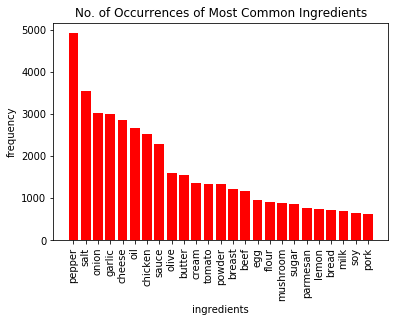

<Figure size 1080x1080 with 0 Axes>

In [86]:
most_occur = ings_count.most_common(25)

word, frequency = zip(*most_occur)
indices = np.arange(len(word))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.xlabel('ingredients')
plt.ylabel('frequency')
plt.title('No. of Occurrences of Most Common Ingredients')
# plt.tight_layout()

plt.figure(figsize=(15,15))
plt.show()

In [147]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=2, max_df=.7)


#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df.liststring)

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(5538, 634)

In [979]:
with open("lemmas.txt", "wb") as fp:   #Pickling
    pickle.dump(lemmas, fp)

In [980]:
with open("lemmas.txt", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [985]:
from google_images_search import GoogleImagesSearch

In [768]:
df_final['lemmas'] = lemmas

In [700]:
df_final.drop(columns=['ings'],inplace =True)

In [ ]:
for val in parsed_ingredients[28]:
    pp = nlp(val)
    for p in pp:
#         if p.pos_ != 'VERB' and p.pos_ != 'CCONJ' and p.pos_ != 'DET' and p.pos_ != 'PUNCT' and p.pos_ != 'PART' and p.pos_ != 'ADP' and p.dep_ != 'conj' and p.dep_ != 'nsubj' and p.dep_ != 'nmod':
        print(p.text,p.lemma_,p.pos_,p.tag_,p.dep_)

In [408]:
df_final.head()

name  \
0  World's Best Lasagna                      
1  Pork Chops in Garlic Mushroom Sauce       
2  Super Duper Slow Cooker Beef Stroganoff   
3  Chef John's Perfect Prime Rib             
4  Beef Stroganoff for Instant Pot®          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ingredients  \
0  ['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']   
1  ['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']                                                                                                                                                                                                                                                                                                                                            
2  ['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']                                                                                                                       
3  ['4 pounds prime rib roast', '1/4 cup unsalted butter, softened', '1 tablespoon freshly ground black pepper', '1 teaspoon herbes de Provence', 'kosher salt']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
4  ['2 tablespoons canola oil', '1/2 onion, diced', '2 teaspoons salt, divided', '2 pounds beef stew meat, cut into 1-inch cubes', '1 teaspoon freshly ground black pepper', '3 cloves garlic, minced', '1/2 teaspoon dried thyme', '2 tablespoons soy sauce', '3 cups chopped mushrooms', '2 tablespoons all-purpose flour', '3 cups chicken broth', '1 (16 ounce) package wide egg noodles', '3/4 cup sour cream, or to taste']                                                                                                                                                                                        

In [21]:
# Reorder Columns
cols = df_final.columns.to_list()

new_cols = ['name', 'ingredients','instructions','ings_str1','cleaned_ings','calories_g',
            'fat_g', 'carbohydrates_g','protein_g','cholesterol_mg','sodium_mg','prep_time',
            'cook_time','total_time','avg_rating','image']

df_final = df_final[new_cols]

In [24]:
df_final.head()

name  \
0  World's Best Lasagna                      
1  Pork Chops in Garlic Mushroom Sauce       
2  Super Duper Slow Cooker Beef Stroganoff   
3  Chef John's Perfect Prime Rib             
4  Beef Stroganoff for Instant Pot®          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ingredients  \
0  ['1 pound sweet Italian sausage', '3/4 pound lean ground beef', '1/2 cup minced onion', '2 cloves garlic, crushed', '1 (28 ounce) can crushed tomatoes', '2 (6 ounce) cans tomato paste', '2 (6.5 ounce) cans canned tomato sauce', '1/2 cup water', '2 tablespoons white sugar', '1 1/2 teaspoons dried basil leaves', '1/2 teaspoon fennel seeds', '1 teaspoon Italian seasoning', '1 1/2 teaspoons salt, divided, or to taste', '1/4 teaspoon ground black pepper', '4 tablespoons chopped fresh parsley', '12 lasagna noodles', '16 ounces ricotta cheese', '1 egg', '3/4 pound mozzarella cheese, sliced', '3/4 cup grated Parmesan cheese']   
1  ['2 pounds boneless pork chops', '1/2 teaspoon paprika', '1 pinch kosher salt and ground black pepper to taste', '1/4 cup butter, divided', '1 (8 ounce) package sliced fresh mushrooms', '4 cloves garlic, minced', '1 teaspoon Dijon mustard', '2 tablespoons all-purpose flour', '2 cups beef broth']                                                                                                                                                                                                                                                                                                                                            
2  ['1 1/2 pounds cubed beef stew meat', 'salt and ground black pepper to taste', '1 onion, chopped', '1 (10.75 ounce) can condensed cream of mushroom soup', '1/4 cup water', '1 tablespoon dried chives', '2 cloves garlic, minced', '1 tablespoon Worcestershire sauce', '1 cube beef bouillon', '1/2 cup red wine', '1 tablespoon cornstarch', '1 tablespoon all-purpose flour', '1 (8 ounce) container sour cream', '1 (8 ounce) package sliced fresh mushrooms', '4 ounces cream cheese', '1/2 cup chopped fresh parsley']                                                                                                                       
3  ['4 pounds prime rib roast', '1/4 cup unsalted butter, softened', '1 tablespoon freshly ground black pepper', '1 teaspoon herbes de Provence', 'kosher salt']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
4  ['2 tablespoons canola oil', '1/2 onion, diced', '2 teaspoons salt, divided', '2 pounds beef stew meat, cut into 1-inch cubes', '1 teaspoon freshly ground black pepper', '3 cloves garlic, minced', '1/2 teaspoon dried thyme', '2 tablespoons soy sauce', '3 cups chopped mushrooms', '2 tablespoons all-purpose flour', '3 cups chicken broth', '1 (16 ounce) package wide egg noodles', '3/4 cup sour cream, or to taste']                                                                                                                                                                                        

In [701]:
# Save final CSV
df_final.to_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/all_info1.csv',index=False)

In [956]:
my_info = df_final.drop(columns=['cleaned_ings', 'all_text'])

In [959]:
# Save final CSV
my_info.to_csv(r'/Users/stephaniekendall/Desktop/Errthang/Flatiron/projects/FP_Practice/my_info.csv',index=False)

### Make Recommendations

In [106]:
# Add the text columns together for NLP

df_final["all_text"] = df_final["ings_str1"].map(str) + ", "+df_final["instructions"]

In [126]:
def no_digits(doc):
    no_digits = [t for t in doc if t != t.isdigit()]
    return(no_digits)

In [128]:
no_nums = [no_digits(num) for num in keywords]

In [133]:
processed_keywords[0]

['sweet',
 'italian',
 'sausage',
 'lean',
 'ground',
 'beef',
 'onion',
 'garlic',
 'tomatoes',
 'tomato',
 'paste',
 'tomato',
 'sauce',
 'water',
 'white',
 'sugar',
 'basil',
 'leaves',
 'fennel',
 'seeds',
 'italian',
 'seasoning',
 'black',
 'pepper',
 'parsley',
 'lasagna',
 'noodles',
 'ricotta',
 'cheese',
 'eggs',
 'mozzarella',
 'cheese',
 'parmesan',
 'cheese',
 'in',
 'a',
 'dutch',
 'oven',
 'cook',
 'sausage',
 'ground',
 'beef',
 'onion',
 'and',
 'garlic',
 'over',
 'medium',
 'heat',
 'until',
 'well',
 'browned',
 '.',
 'stir',
 'in',
 'crushed',
 'tomatoes',
 'tomato',
 'paste',
 'tomato',
 'sauce',
 'and',
 'water',
 '.',
 'season',
 'with',
 'sugar',
 'basil',
 'fennel',
 'seeds',
 'italian',
 'seasoning',
 '1',
 'teaspoon',
 'salt',
 'pepper',
 'and',
 '2',
 'tablespoons',
 'parsley',
 '.',
 'simmer',
 'covered',
 'for',
 'about',
 '1',
 '1/2',
 'hours',
 'stirring',
 'occasionally',
 '.',
 'bring',
 'a',
 'large',
 'pot',
 'of',
 'lightly',
 'salted',
 'water',


In [716]:
lemmas[0:3]

[['sweet',
  'italian',
  'sausage',
  'lean',
  'beef',
  'onion',
  'garlic',
  'tomato',
  'paste',
  'canned',
  'sauce',
  'water',
  'white',
  'sugar',
  'fennel',
  'seasoning',
  'salt',
  'black',
  'pepper',
  'fresh',
  'parsley',
  'lasagna',
  'ricotta',
  'cheese',
  'egg',
  'mozzarella',
  'Parmesan'],
 ['boneless',
  'pork',
  'paprika',
  'kosher',
  'black',
  'pepper',
  'butter',
  'fresh',
  'garlic',
  'Dijon',
  'mustard',
  'flour',
  'beef',
  'broth'],
 ['beef',
  'stew',
  'meat',
  'black',
  'pepper',
  'onion',
  'cream',
  'mushroom',
  'water',
  'garlic',
  'Worcestershire',
  'sauce',
  'bouillon',
  'red',
  'wine',
  'cornstarch',
  'flour',
  'sour',
  'fresh',
  'cheese',
  'parsley']]

In [150]:

# Processing Keywords
# flatten list for count of values
flat_list = [' '.join(x) for x in tokenz]

# keywords = df_final['lemmas'].tolist()

from nltk.tokenize import word_tokenize
keywords = [word_tokenize(keyword.lower()) for keyword in flat_list]

def no_commas(doc):
    no_commas = [t for t in doc if t!=',']
    return(no_commas)

keywords = [no_commas(kw) for kw in keywords]
processed_keywords = keywords

In [151]:
flat_list[0]

'sausage beef onion clove garlic tomato tomato tomato sauce sugar basil fennel salt pepper parsley lasagna noodle ricotta cheese egg mozzarella cheese parmesan cheese'

In [120]:
spacy_tokenizer(flat_list[0])

['sausage',
 'beef',
 'onion',
 'garlic',
 'tomato',
 'sauce',
 'sugar',
 'fennel',
 'salt',
 'pepper',
 'parsley',
 'lasagna',
 'ricotta',
 'cheese',
 'egg',
 'mozzarella',
 'parmesan']

In [137]:
parsed = []
for x in tqdm(flat_list):
    parsed.append(spacy_tokenizer(x))

In [138]:
# Processing Keywords
# flatten list for count of values
flatly = [' '.join(x) for x in parsed]

# keywords = df_final['lemmas'].tolist()

from nltk.tokenize import word_tokenize
keywords1 = [word_tokenize(keyword.lower()) for keyword in flatly]

def no_commas(doc):
    no_commas = [t for t in doc if t!=',']
    return(no_commas)

keywords1 = [no_commas(kw) for kw in keywords1]
processed_keywords = keywords1

In [152]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(processed_keywords) # create a dictionary of words from our keywords

corpus = [dictionary.doc2bow(doc) for doc in processed_keywords] 
#create corpus where the corpus is a bag of words for each document

from gensim.models.tfidfmodel import TfidfModel
tfidf = TfidfModel(corpus) #create tfidf model of the corpus

from gensim.similarities import MatrixSimilarity
# Create the similarity data structure. This is the most important part where we get the similarities between the recipes
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))

In [147]:
import pickle
with open('tfidf_matrix.pickle', 'wb') as f:
    pickle.dump(tfidf, f)

In [148]:
import pickle
with open('sims_matrix.pickle', 'wb') as f:
    pickle.dump(sims, f)

In [154]:
inst.head()

name  \
0  World's Best Lasagna                      
1  Pork Chops in Garlic Mushroom Sauce       
2  Super Duper Slow Cooker Beef Stroganoff   
3  Chef John's Perfect Prime Rib             
4  Beef Stroganoff for Instant Pot®          

                                                                image  \
0  https://images.media-allrecipes.com/userphotos/560x315/3359675.jpg   
1  https://images.media-allrecipes.com/userphotos/560x315/6308774.jpg   
2  https://images.media-allrecipes.com/userphotos/560x315/7466519.jpg   
3  https://images.media-allrecipes.com/userphotos/560x315/4886145.jpg   
4  https://images.media-allrecipes.com/userphotos/560x315/6472891.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 instructions  
0  In a Dutch oven, cook sausage, ground beef, onion, and garlic over medium heat until well browned. Stir in crushed tomatoes, tomato paste, tomato sauce, and water. Season with sugar, basil, fennel seeds, Italian seasoning, 1 teaspoon salt, pepper, and 2 tablespoons parsley. Simmer, covered, for about 1 1/2 hours, stirring occasionally.\nBring a large pot of lightly salted water to a boil. Cook lasagna noodles in boiling water for 8 to 10 minutes. Drain noodles, and rinse with cold water. In a mixing bowl, combine ricotta cheese with egg, remaining parsley, and 1/2 teaspoon salt.\nPreheat oven to 375 degrees F (190 degrees C).\nTo assemble, spread 1 1/2 cups of meat sauce in the bottom of a 9x13 inch baking dish. Arrange 6 noodles lengthwise over meat sauce. Spread with one half of the ricotta cheese mixture. Top with a third of mozzarella cheese slices. Spoon 1 1/2 cups meat sauce over mozzarella, and sprinkle with 1/4 cup Parmesan cheese. Repeat layers, and top with remaining mozzarella and Parmesan cheese. Cover with foil: to prevent sticking, either spray foil with cooking spray, or make sure the foil does not touch the cheese.\nBake in preheated oven for 25 minutes. Remove foil, and bake an additional 25 minutes. Cool for 15 minutes before serving.\n  
1  Season both sides of pork chops with paprika, salt, and pepper.\nHeat a large skillet over medium-high heat; add 2 tablespoons butter. Sear pork chops until golden brown and no longer pink in the center, 2 to 4 minutes per side. Remove pork chops from the skillet and set aside.\nMelt remaining butter in the same skillet over medium-high heat. Add mushrooms and cook until golden and excess moisture evaporates, about 5 minutes. Add garlic and mustard; cook until garlic is fragrant, about 1 minute.\nAdd flour to the skillet, stirring to remove any lumps. Slowly add beef broth, whisking until incorporated. Season with salt and pepper. Reduce heat to medium and simmer, stirring often, until sauce thickens, about 5 minutes. Check for seasoning again.\nRet

In [155]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def Pics(img_urls):
#     print(color.BOLD + df.Name.iloc[img_urls] + color.END)

    urls = [url for url in inst.image[image].split(',')]
#         resim = []
    images = []
    for i in range(0, len(urls)-1):
        url = urls[i].strip() 

#         print(url)
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))           
        images.append(img)

        if img.size[0] >125:

            plt.imshow(img)
            plt.figure()

In [173]:
# images = []
for url in tqdm(inst.image[3289]):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))           
        images.append(img)
    except:
        sorry = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2016/01/12/16/sorry-note-rex.jpg?w968'
        response1 = requests.get(sorry)
        img1 = Image.open(BytesIO(response1.content))
        images.append(img1)

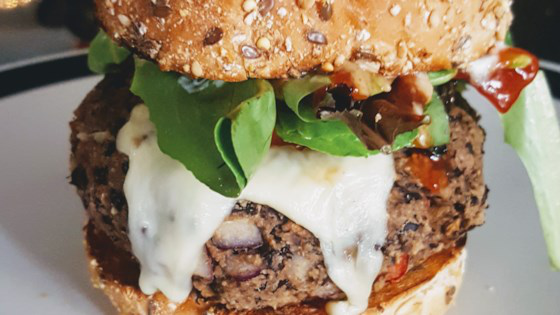

In [177]:
images[55]

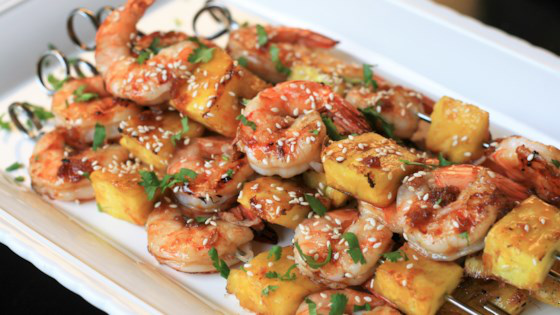

In [166]:
images[5]

### Make Recommendations Using Keywords

In [204]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the movie ID and it's tf-idf value for the recipe

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our ingredients and every other recipe. 
    #So the length is the number of recipes we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=df.name.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar recipes
    
    # Get the recipe indices
    rec_indices = [i[0] for i in df]
    
    # Print the top matching recipes
    print("Our top %s most similar recipes for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (recipe) in enumerate(zip(top_hits.index, top_hits)):
        print("%d ranked recipe and similarity score'%s' " %(idx+1, recipe))

In [187]:
rec_indices = [i[0] for i in df.name]

In [207]:
keywords_recommendation(['chicken','lemon','pepper','rosemary'],5)

Our top 5 most similar recipes for the keywords ['chicken', 'lemon', 'pepper', 'rosemary'] are:
1 ranked recipe and similarity score'('Easy Garlic and Rosemary Chicken', 0.8915821313858032)' 
2 ranked recipe and similarity score'('Roasted Chicken with Lemon and Rosemary', 0.877566397190094)' 
3 ranked recipe and similarity score'('Marinated Rosemary Lemon Chicken', 0.8726105690002441)' 
4 ranked recipe and similarity score'('Robust Garlic Baked Chicken', 0.8626155257225037)' 
5 ranked recipe and similarity score'('Rosemary Lemon Grilled Chicken', 0.860939621925354)' 


In [182]:
keywords_recommendation(['shrimp','garlic','pepper'],5)

Our top 5 most similar recipes for the keywords ['shrimp', 'garlic', 'pepper'] are:
1 ranked recipe and similarity score'('Sexy Shrimp Scampi', 0.8030396699905396)' 
2 ranked recipe and similarity score'('Broiled Shrimp Scampi', 0.7329943776130676)' 
3 ranked recipe and similarity score'('Deep Fried Shrimp', 0.6962694525718689)' 
4 ranked recipe and similarity score'('Louisiana Shrimp Casserole', 0.6821331977844238)' 
5 ranked recipe and similarity score'('Garlic Cheese Grits with Shrimp', 0.5962445139884949)' 


In [220]:
keywords_recommendation(['pepper'],5)

Our top 5 most similar recipes for the keywords ['steak', 'pepper'] are:
1 ranked recipe and similarity score'('Grilled Delmonico Steaks', 0.7849744558334351)' 
2 ranked recipe and similarity score'('BBQ NY Strip', 0.781780481338501)' 
3 ranked recipe and similarity score'('Country Fried Steak', 0.7655466198921204)' 
4 ranked recipe and similarity score'("Poor Man's Pepper Steak", 0.757615327835083)' 
5 ranked recipe and similarity score'('Yummy Meatloaf', 0.7260258793830872)' 


In [259]:
keywords = df_final['xgrams'].tolist()
keywords = [word_tokenize(keyword.lower()) for keyword in keywords]
keywords = [no_commas(kw) for kw in keywords]

In [743]:
# generate unigrams 
unigrams  = (
    df_final['lemmas'].to_list())

# generate bigrams by concatenating unigram columns
bigrams = unigrams + ' ' + unigrams.shift(-1)
# generate trigrams by concatenating unigram and bigram columns
trigrams = bigrams + ' ' + unigrams.shift(-2)

# concatenate all series vertically, and remove NaNs
xgrams = pd.concat([unigrams, bigrams, trigrams]).dropna().reset_index(drop=True)

AttributeError: 'Series' object has no attribute 'stack'

In [772]:
lemmas[0]

['sweet',
 'italian',
 'sausage',
 'lean',
 'beef',
 'onion',
 'garlic',
 'tomato',
 'paste',
 'canned',
 'sauce',
 'water',
 'white',
 'sugar',
 'fennel',
 'seasoning',
 'salt',
 'black',
 'pepper',
 'fresh',
 'parsley',
 'lasagna',
 'ricotta',
 'cheese',
 'egg',
 'mozzarella',
 'Parmesan']

In [785]:
def ngrams(input, n):
#     input = input.split(' ')
    output = []
    for i in range(len(input)-n+1):
        output.append(input[i:i+n])
    return output

In [786]:
ngrams(lemmas[1],2)

[['pork', 'paprika'],
 ['paprika', 'kosher'],
 ['kosher', 'black'],
 ['black', 'pepper'],
 ['pepper', 'butter'],
 ['butter', 'fresh'],
 ['fresh', 'garlic'],
 ['garlic', 'Dijon'],
 ['Dijon', 'mustard'],
 ['mustard', 'flour'],
 ['flour', 'beef'],
 ['beef', 'broth']]

In [809]:
all_bigrams = [ngrams(x,2) for x in lemmas]

In [826]:
clean_bigrams = []
for big in all_bigrams:
    bins = []
    for b in big:
        bins.append(str(b).replace('[','').replace(']','').replace("'",'').replace(', ','-'))
    clean_bigrams.append(bins)

In [827]:
df_final['bigrams'] = clean_bigrams

In [954]:
from collections import defaultdict
import itertools
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)

# Print the top 20 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:20]:
    print(dictionary_keywords.get(word_id), word_count)

seeds 2731
garlic 2654
leaves 2642
roast 2266
water 2230
rib 1888
lean 1851
italian 1849
seasoning 1690
onion 1465
mozzarella 1351
jack 1286
allpurpose 1013
ricotta 954
hot 947
cheese 946
sweet 926
stew 842
juice 823
pork 820


In [801]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the recipe name and it's tf-idf value for the recipe

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our recipe and every other recipe. 
    #So the length is the number of recipe we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=df_final.name.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar recipes

    # Print the top matching eecipes
    print("Our top %s most similar recipes for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (recipe,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, recipe, score))

In [970]:
keywords_recommendation(['chicken','garlic','pepper'],8)

Our top 8 most similar recipes for the keywords ['chicken', 'garlic', 'pepper'] are:
1 'Easy Baked Chicken Thighs' with a similarity score of 0.719
2 'Creamy Chicken' with a similarity score of 0.564
3 'Gina's Lemon Pepper Chicken' with a similarity score of 0.517
4 'Easy Cheesy Chicken II' with a similarity score of 0.441
5 'Caryn's Chicken' with a similarity score of 0.431
6 'Greasy Chicken' with a similarity score of 0.425
7 'Moist Garlic Roasted Chicken' with a similarity score of 0.418
8 'Three-Ingredient Baked Chicken Breasts' with a similarity score of 0.412


### More EDA

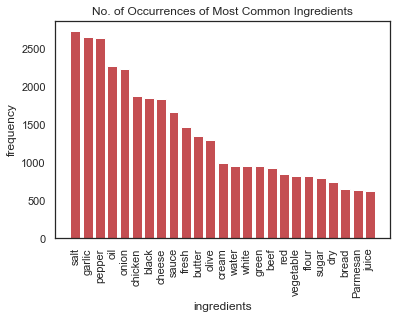

<Figure size 1080x1080 with 0 Axes>

In [804]:
# # flatten list for count of values
flat_lems = [item for sublist in lemmas for item in sublist]

# create bar chart for 25 most common words
w = Counter(flat_lems)
most_occur = w.most_common(25)

word, frequency = zip(*most_occur)
indices = np.arange(len(word))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.xlabel('ingredients')
plt.ylabel('frequency')
plt.title('No. of Occurrences of Most Common Ingredients')
# plt.tight_layout()

plt.figure(figsize=(15,15))
plt.show()

In [764]:
w.most_common(100)

[('salt', 2730),
 ('garlic', 2650),
 ('pepper', 2636),
 ('oil', 2266),
 ('onion', 2227),
 ('chicken', 1873),
 ('black', 1846),
 ('cheese', 1832),
 ('sauce', 1667),
 ('fresh', 1465),
 ('butter', 1349),
 ('olive', 1286),
 ('powder', 1041),
 ('cream', 986),
 ('water', 954),
 ('white', 946),
 ('green', 945),
 ('beef', 923),
 ('red', 840),
 ('vegetable', 823),
 ('flour', 819),
 ('sugar', 791),
 ('dry', 739),
 ('bread', 646),
 ('Parmesan', 632),
 ('juice', 616),
 ('milk', 605),
 ('lemon', 603),
 ('soy', 596),
 ('bell', 596),
 ('pork', 577),
 ('parsley', 556),
 ('brown', 554),
 ('broth', 549),
 ('tomato', 545),
 ('wine', 522),
 ('egg', 518),
 ('vinegar', 484),
 ('seasoning', 474),
 ('Cheddar', 472),
 ('pasta', 439),
 ('italian', 436),
 ('mustard', 435),
 ('rice', 421),
 ('oregano', 404),
 ('ginger', 389),
 ('basil', 378),
 ('cayenne', 363),
 ('paprika', 359),
 ('mozzarella', 353),
 ('sour', 348),
 ('Worcestershire', 336),
 ('celery', 336),
 ('cumin', 321),
 ('uncooked', 319),
 ('inch', 292),


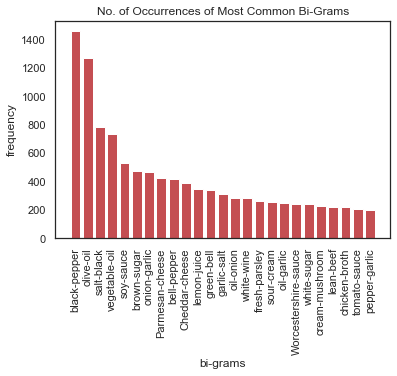

<Figure size 2880x2880 with 0 Axes>

In [932]:
# # flatten list for count of values
flat_bigs = [item for sublist in clean_bigrams for item in sublist]

# create bar chart for 25 most common words
wb = Counter(flat_bigs)
most_occurb = wb.most_common(25)

wordb, frequencyb = zip(*most_occurb)
indicesb = np.arange(len(wordb))
plt.bar(indicesb, frequencyb, color='r')
plt.xticks(indicesb, wordb, rotation='vertical')
plt.xlabel('bi-grams')
plt.ylabel('frequency')
plt.title('No. of Occurrences of Most Common Bi-Grams')
# plt.tight_layout()

plt.figure(figsize=(40,40))
plt.show()

In [841]:
wb.most_common(100)

[('black-pepper', 1457),
 ('olive-oil', 1269),
 ('salt-black', 779),
 ('vegetable-oil', 730),
 ('soy-sauce', 526),
 ('brown-sugar', 472),
 ('onion-garlic', 467),
 ('Parmesan-cheese', 421),
 ('bell-pepper', 419),
 ('Cheddar-cheese', 387),
 ('lemon-juice', 349),
 ('green-bell', 338),
 ('garlic-salt', 309),
 ('oil-onion', 285),
 ('white-wine', 283),
 ('fresh-parsley', 259),
 ('sour-cream', 254),
 ('oil-garlic', 248),
 ('Worcestershire-sauce', 242),
 ('white-sugar', 237),
 ('cream-mushroom', 229),
 ('lean-beef', 222),
 ('chicken-broth', 221),
 ('tomato-sauce', 204),
 ('pepper-garlic', 197),
 ('red-bell', 197),
 ('red-pepper', 191),
 ('dry-bread', 188),
 ('cayenne-pepper', 187),
 ('garlic-fresh', 180),
 ('mozzarella-cheese', 175),
 ('oil-chicken', 172),
 ('fresh-ginger', 164),
 ('beef-onion', 163),
 ('Dijon-mustard', 159),
 ('onion-green', 154),
 ('butter-onion', 153),
 ('white-rice', 152),
 ('garlic-onion', 142),
 ('flour-salt', 129),
 ('fresh-cilantro', 128),
 ('red-wine', 123),
 ('pepper

In [76]:
# Make a DataFrame of only the Continuous Variables
nutfacts = df_final.drop(columns=['ingredients', 'instructions','ings_str1','cleaned_ings', 'prep_time','cook_time','image'])
nutfacts.head()

name  calories_g  fat_g  \
0  World's Best Lasagna                     448.0       21.3    
1  Pork Chops in Garlic Mushroom Sauce      199.0       13.4    
2  Super Duper Slow Cooker Beef Stroganoff  394.0       24.2    
3  Chef John's Perfect Prime Rib            1757.0      160.6   
4  Beef Stroganoff for Instant Pot®         536.0       26.2    

   carbohydrates_g  protein_g  cholesterol_mg  sodium_mg  total_time  \
0  36.5             29.7       82.0            1400.0     195.0        
1  3.1              16.3       54.0            333.0      30.0         
2  14.3             26.3       97.0            629.0      435.0        
3  1.0              72.5       362.0           343.0      390.0        
4  45.2             29.0       121.0           1312.0     62.0         

   avg_rating  
0  4.80        
1  4.61        
2  4.63        
3  4.77        
4  4.46

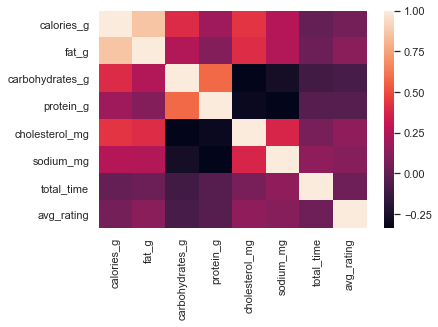

In [85]:
# See the most correlated values
fig = plt.figure()
ax = plt.subplot(111)
corr = nutfacts.corr()
ax = sns.heatmap(corr)
plt.savefig('heatmap.pdf',bbox_inches='tight')
plt.show()

In [930]:
import plotly.express as px

#drop column of names for matrix
noname = nutfacts.drop(columns=['name'])

fig = px.scatter_matrix(noname)

fig.update_layout(
    title='Scatter Matrix of Continuous Features',
    dragmode='select',
    width=900,
    height=900,
    hovermode='closest',)
fig.show()

### Look at Outliers

In [103]:
# Calories

nutfacts.loc[nutfacts['calories_g'] > 2000]

name  calories_g  fat_g  carbohydrates_g  protein_g  \
5047  Easy Homemade Pastrami  4709.0      383.9  32.6             273.2       

      cholesterol_mg  sodium_mg  total_time  avg_rating  
5047  980.0           22099.0    945.0       4.69

In [38]:
# Fat

nutfacts.loc[nutfacts['fat_g'] > 300]

name  calories_g  fat_g  carbohydrates_g  protein_g  \
5047  Easy Homemade Pastrami  4709.0      383.9  32.6             273.2       

     cholesterol_mg  sodium_mg  total_time  avg_rating  
5047  980            22099.0    945.0       4.69

In [39]:
# Carbs

nutfacts.loc[nutfacts['carbohydrates_g'] > 450]

name  calories_g  fat_g  carbohydrates_g  \
2328  Southern Fried Chicken Livers  470.0       28.9   459.0             

      protein_g cholesterol_mg  sodium_mg  total_time  avg_rating  
2328  86.0       27.5           24.0       20.0        4.71

In [40]:
# Protein

nutfacts.loc[nutfacts['protein_g'] > 4000]

name  calories_g  fat_g  carbohydrates_g  \
1161  Chef John's Salt Roasted Chicken    554.0       35.7   185.0             
1434  The Best Ever Chicken Nuggets       515.0       17.8   162.0             
1922  Hawaiian Chicken I                  548.0       18.2   108.0             
1949  Honey-Brined Fried Chicken Breasts  481.0       21.5   65.0              
2423  Cherry Bomb Chicken                 490.0       25.3   129.0             
3480  Mariu's Spaghetti with Meat Sauce   627.0       27.8   72.0              

      protein_g cholesterol_mg  sodium_mg  total_time  avg_rating  
1161  4604.0     1.2            53.7       75.0        4.68        
1434  4175.0     51.2           35.6       45.0        4.56        
1922  5831.0     63.2           32.5       510.0       4.50        
1949  6378.0     49.4           22.8       105.0       4.55        
2423  5252.0     22.6           41.5       340.0       4.77        
3480  4578.0     65.7           28.1       165.0       4.59

In [46]:
# Sodium

nutfacts.loc[nutfacts['sodium_mg'] > 20000]

name  calories_g  fat_g  \
1013  Kosher Salt Encrusted Prime Rib Roast  391.0       25.8    
5047  Easy Homemade Pastrami                 4709.0      383.9   

      carbohydrates_g  protein_g cholesterol_mg  sodium_mg  total_time  \
1013  1.2              36.1       107            30921.0    280.0        
5047  32.6             273.2      980            22099.0    945.0        

      avg_rating  
1013  4.72        
5047  4.69

In [54]:
# Rating

nutfacts.loc[nutfacts['avg_rating'] < 2]

name  calories_g  fat_g  \
13  Al's Burmese Chicken Curry                       527.0       34.3    
14  Gemelli Pasta with Roasted Pumpkin and Pancetta  356.0       13.6    

    carbohydrates_g  protein_g cholesterol_mg  sodium_mg  total_time  \
13  22.6             34.6       108            814.0      180.0        
14  45.8             13.8       16             730.0      55.0         

    avg_rating  
13  0.0         
14  0.0

In [78]:
# Cholesterol

nutfacts.loc[nutfacts['cholesterol_mg'] > 700]

name  calories_g  fat_g  carbohydrates_g  protein_g  \
2818  Beer-Boiled Shrimp      1030.0      67.9   12.1             78.6        
4724  Deep Fried Shrimp       493.0       15.0   24.8             61.1        
5047  Easy Homemade Pastrami  4709.0      383.9  32.6             273.2       

      cholesterol_mg  sodium_mg  total_time  avg_rating  
2818  738.0           2167.0     70.0        4.32        
4724  709.0           1092.0     20.0        3.35        
5047  980.0           22099.0    945.0       4.69

### Look at Correlations minus Outliers

In [927]:
nooutliers = nutfacts.loc[nutfacts['calories_g'] < 2000]
nooutliers = nooutliers.loc[nooutliers['fat_g'] < 300]
nooutliers = nooutliers.loc[nooutliers['carbohydrates_g'] < 450]
nooutliers = nooutliers.loc[nooutliers['protein_g'] < 4000]
nooutliers = nooutliers.loc[nooutliers['sodium_mg'] < 20000]
nooutliers = nooutliers.loc[nooutliers['avg_rating'] > 2]
nooutliers = nooutliers.loc[nooutliers['cholesterol_mg'] < 700]

fig = px.scatter_matrix(nooutliers.drop(columns=['name']))
fig.update_layout(
    title='Scatter Matrix of Continuous Features without Outliers',
    dragmode='select',
    width=900,
    height=900,
    hovermode='closest',)
fig.show()

### Histograms for each column

In [135]:
# Calories

fig = px.histogram(nutfacts, x="calories_g")
fig.show()

In [92]:
# Fat

fig = px.histogram(nutfacts, x="fat_g")
fig.show()

In [93]:
# Carbs

fig = px.histogram(nutfacts, x="carbohydrates_g")
fig.show()

In [94]:
# Protein

fig = px.histogram(nutfacts, x="protein_g")
fig.show()

In [95]:
# Cholesterol

fig = px.histogram(nutfacts, x="cholesterol_mg")
fig.show()

In [96]:
# Sodium

fig = px.histogram(nutfacts, x="sodium_mg")
fig.show()

In [951]:
# Rating

fig = px.histogram(nutfacts, x="avg_rating")

fig.update_layout(
    title="Average Recipe Rating Distribution",
    xaxis_title="average rating",
    yaxis_title="frequency",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ))

fig.show()

In [953]:
# Rating

fig = px.histogram(nutfacts, x="total_time")


fig.update_layout(
    title="Total Time for Recipe Completion Distribution",
    xaxis_title="total time (min)",
    yaxis_title="frequency",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    ))
fig.show()

In [ ]:
py.iplot(fig, filename='histogram-discrete-freq-count')

### Worldcloud

In [890]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [908]:
one_list = []
for lists in flat_list:
    for l in lists.split():
        if l not in one_list:
            one_list.append(l.replace)

In [917]:
str(one_list).replace("[",'').replace("]",'').replace("'",'')

'sweet, italian, sausage, lean, beef, onion, garlic, tomato, paste, canned, sauce, water, white, sugar, fennel, seasoning, salt, black, pepper, fresh, parsley, lasagna, ricotta, cheese, egg, mozzarella, Parmesan, pork, paprika, kosher, butter, Dijon, mustard, flour, broth, stew, meat, cream, mushroom, Worcestershire, bouillon, red, wine, cornstarch, sour, prime, rib, roast, unsalted, herbes, de, Provence, canola, oil, soy, chicken, wide, brown, honey, ginger, jumbo, shrimp, pineapple, cilantro, sesame, poblano, lengthwise, low, sodium, long, grain, rice, packet, taco, lime, frozen, roasted, corn, Trader, Cheddar, Monterey, Jack, blend, olive, panko, bread, small, basil, provolone, plain, milk, herb, chuck, celery, curry, coriander, asian, spice, turmeric, cardamom, grapeseed, maple, syrup, salmon, light, chipotle, chili, potato, apple, cider, granulated, chile, garam, masala, hot, lemongrass, birds, eye, kaffir, fish, pumpkin, virgin, gemelli, pasta, pancetta, Parmigiano, reggiano, liq

In [918]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(str(one_list).replace("[",'').replace("]",'').replace("'",''))

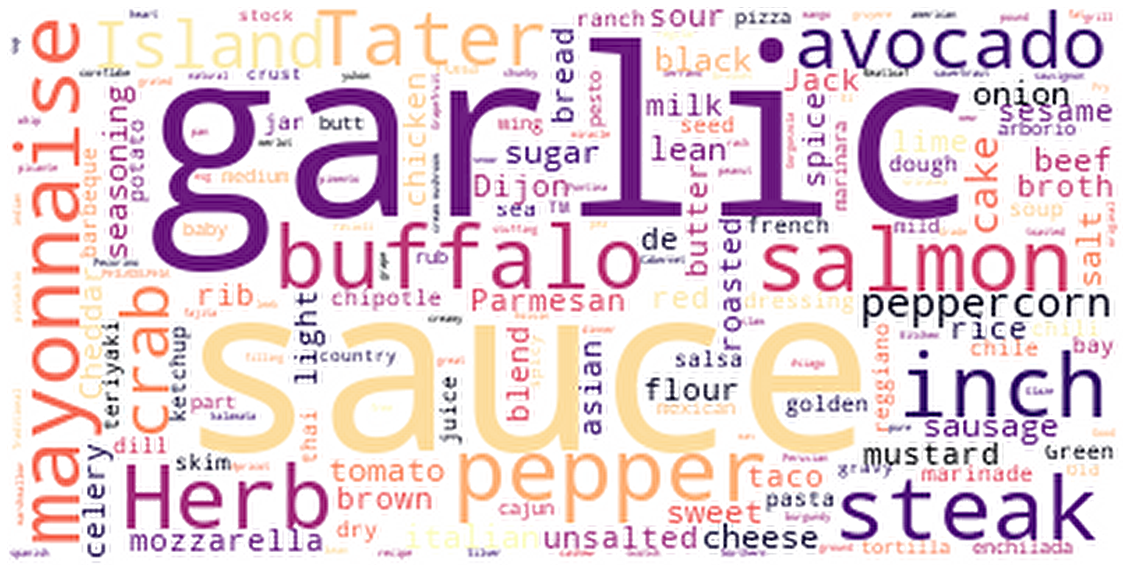

<Figure size 432x288 with 0 Axes>

In [921]:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()
plt.savefig('wordcloud.png')

### NLP

In [166]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Create functions for making alpha, removing stop words, and lemmatizing
def make_alpha(doc):
    # Retain alphabetic words: alpha_only
    alpha_only = [t for t in doc if t.isalpha()]    
    return(alpha_only)
def remove_stops(doc):
    no_stops = [t for t in doc if t not in stopwords.words('english')]
    return(no_stops)
def lemmatize(doc):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in doc]
    return(lemmatized)
def no_commas(doc):
    no_commas = [t for t in doc if t!=',']
    return(no_commas)

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1056)>


In [282]:
all_text = df_final['ings_str1'].str.split(',').tolist()

In [168]:

all_text = [word_tokenize(outline.lower()) for outline in all_text] #lowecase the words and tokenize them
all_text = [make_alpha(outline) for outline in all_text] 
all_text = [remove_stops(outline) for outline in all_text] 
all_text  = [lemmatize(outline) for outline in all_text] 

In [828]:
from gensim.corpora.dictionary import Dictionary
dictionary_outlines = Dictionary(clean_bigrams)
corpus = [dictionary_outlines.doc2bow(outline) for outline in clean_bigrams]

# Create the defaultdict: total_word_count
# This dictionary contains every word ID and its corresponding number of times it appears in the corpus
from collections import defaultdict
import itertools
total_word_count = defaultdict(int)
for word_id, word_count in itertools.chain.from_iterable(corpus):
    total_word_count[word_id] += word_count

# Create a sorted list from the defaultdict: sorted_word_count
sorted_word_count = sorted(total_word_count.items(), key=lambda w: w[1], reverse=True)

# Print the top 20 words across all documents alongside the count
for word_id, word_count in sorted_word_count[:5]:
    print(dictionary_outlines.get(word_id), word_count)

black-pepper 1457
olive-oil 1269
salt-black 779
vegetable-oil 730
soy-sauce 526


### More Recommendations

In [842]:
from math import e

class RatingExtractor:
    def __init__(self):
        print("rating initialized")

    # Version-4

    #Returns overall rating score
    #Parameters:
        #r: indicates the rating for the destination
        #rc: rating count
        #pf: positive feedback count
        #bf: negative feedback count
    @staticmethod
    def get_rating_weight_with_count_and_reviews(r, rc, pf, bf):
        if r > 10 or r < 0:
            return None
        else:
            positive_diff = (10 - r) / 2
            positive_rating = r + positive_diff

            negative_diff = r / 2
            negative_rating = r - negative_diff

            updated_rating = ((r * rc) + (pf * positive_rating) + (bf * negative_rating)) / (rc + pf + bf)

            return RatingExtractor.get_rating_weight_with_quantity(updated_rating,rc,1000000,100)

In [843]:
import re, math
from collections import Counter

class CosineSimilarity:
    def __init__(self):
        print("Cosine Similarity initialized")

    @staticmethod
    def cosine_similarity_of(text1, text2):
        #get words first
        first = re.compile(r"[\w']+").findall(text1)
        second = re.compile(r"[\w']+").findall(text2)

        #get dictionary with each word and count.
        vector1 = Counter(first)
        vector2 = Counter(second)

        #convert vectors to set to find common words as intersection
        common = set(vector1.keys()).intersection(set(vector2.keys()))

        dot_product = 0.0

        for i in common:
            #get amount of each common word for both vectors and multiply them then add them together.
            dot_product += vector1[i] * vector2[i]

        squared_sum_vector1 = 0.0
        squared_sum_vector2 = 0.0

        #get squared sum values of word counts from each vector.
        for i in vector1.keys():
            squared_sum_vector1 += vector1[i]**2

        for i in vector2.keys():
            squared_sum_vector2 += vector2[i]**2

        #calculate magnitude with squared sums.
        magnitude = math.sqrt(squared_sum_vector1) * math.sqrt(squared_sum_vector2)

        if not magnitude:
            return 0.0
        else:
            return float(dot_product) / magnitude

In [941]:
import numpy as np
import pandas as pd
# from cosine_similarity import CosineSimilarity
import operator
import json

class RecommenderEngine:
    def __init__(self):
        print("engine initialized")

    def get_recommendations(keywords):

        df69 = df_final

        score_dict = {}

        for index, row in df69.iterrows():
            score_dict[index] = CosineSimilarity.cosine_similarity_of(row['ings_str1'], keywords)

        #sort cities by score and index.
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        #create an empty results data frame.
        resultDF = pd.DataFrame(columns=('name', 'ings', 'rating', 'score'))

        #get highest scored 5 cities.
        for i in sorted_scores:
            #print index and score of the city.
            #print(i[0], i[1])
            resultDF = resultDF.append({'name': df_final.iloc[i[0]]['name'], 'ings': df_final.iloc[i[0]]['ings_str1'], 'rating': df_final.iloc[i[0]]['avg_rating'], 'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>4:
                break

        #convert DF to json.
        json_result = json.dumps(resultDF.to_dict('records'))
        return json_result

In [942]:
lobster_keywords = "garlic"
chicken_keywords = "chicken pepper oil"
veggie_keywords = "broccoli cheese pepper"

In [943]:
def get_recommendations(keywords):
    result = RecommenderEngine.get_recommendations(keywords)
    return result

def get_top_5_city_names_out_of_json(json_string):
    list = json.loads(json_string)
    result = []
    max = len(list)
    i = 0
    while i < max:
        result.append((list[i]['name'], list[i]['score']))
        i += 1

    return result

In [944]:
lobster_rec = get_recommendations(lobster_keywords)
lobster_recipes = get_top_5_city_names_out_of_json(lobster_rec)
print(lobster_recipes)

[('Sirloin Steak with Garlic Butter', 0.6324555320336759), ('Mozzarella Mushroom Chicken', 0.5773502691896258), ('Roast Chicken and Vegetables', 0.5773502691896257), ('Chicken Nepiev', 0.5570860145311556), ('Turkey in a Smoker', 0.5547001962252291)]


In [945]:
chicken_rec = get_recommendations(chicken_keywords)
chicken_recipes = get_top_5_city_names_out_of_json(chicken_rec)
print(chicken_recipes)

[('Lemon Pepper Chicken and Gravy', 0.692820323027551), ('Spicy Rapid Roast Chicken', 0.6666666666666667), ('Basic Broiled Chicken Breasts', 0.6546536707079772), ("Tina's Best BBQ Lime Chicken", 0.6405126152203486), ("Denise's Peanut Chicken", 0.6221710168382553)]


In [946]:
veggie_rec = get_recommendations(veggie_keywords)
veggie_recipes = get_top_5_city_names_out_of_json(veggie_rec)
print(veggie_recipes)

[('Creamy Potato Lasagna', 0.5962847939999439), ('Country Pasta with Mozzarella', 0.5962847939999439), ('Chicken Stuffed Baked Avocados', 0.5773502691896258), ('Convenient Vegetarian Lasagna', 0.5773502691896257), ('Broccoli Lasagna', 0.5555555555555556)]


In [ ]:
chicken_keywords = "chicken pepper oil"

In [ ]:
lobster_keywords = "garlic"

In [ ]:
veggie_keywords = "broccoli cheese pepper"

#### With Ratings

In [1059]:
class RecommenderEngine:
    def __init__(self):
        print("engine initialized")

    def calculate_final_score(cs, r):
        amount = (cs / 100) * r

        return cs + amount

    # Version-2
    def get_recommendations_include_rating(keywords):
        df69 = df_final

        score_dict = {}

        for index, row in df69.iterrows():
            cs_score = CosineSimilarity.cosine_similarity_of(row['ings_str1'], keywords)

            rating = row['avg_rating']
            rating_contribution = RatingExtractor.get_rating_weight(rating,10)

            final_score = RecommenderEngine.calculate_final_score(cs_score, rating_contribution)

            score_dict[index] = final_score

        #sort cities by score and index.
        sorted_scores = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=True)

        counter = 0

        #create an empty results data frame.
        resultDF = pd.DataFrame(columns=('name', 'rating', 'score', 'image'))

        #get highest scored 5 cities.
        for i in sorted_scores:
            #print index and score of the city.
            #print(i[0], i[1])
            resultDF = resultDF.append({'name': df69.iloc[i[0]]['name'], 'rating': df69.iloc[i[0]]['avg_rating'], 'ings': df69.iloc[i[0]]['ingredients'], 'img': df69.iloc[i[0]]['image'], 'score': i[1]}, ignore_index=True)
            counter += 1

            if counter>4:
                break

        #convert DF to json.
        return resultDF.to_dict('records')
        

In [1050]:
from math import e

class RatingExtractor:
    def __init__(self):
        print("rating initialized")

    #Returns value between -q and q. for rating input between 0 and 5.
    #Parameters:
        #rating: indicates the rating for the destination
        #q: indicates the percentage of rating for general score. (default is 10)
    @staticmethod
    def get_rating_weight(rating, q=10):
        if rating > 5 or rating < 0:
            return None
        else:
            m = (2*q) / 5 #5 because rating varies between 0 and 5
            b = -q
            return (m*rating) + b

In [1026]:
def get_recommendations_include_rating(keywords):
    return RecommenderEngine.get_recommendations_include_rating(keywords)

In [1099]:
new_keywords = "pepper mushrooms spinach mozzarella"

In [1100]:
new_rec = get_recommendations_include_rating(new_keywords)

In [1101]:
new_rec[1]

{'name': 'Spinach-Stuffed Flounder with Mushrooms and Feta',
 'rating': 4.1,
 'score': 0.4758352656119552,
 'image': nan,
 'img': 'https://images.media-allrecipes.com/userphotos/560x315/2431689.jpg',
 'ings': "['8 large fresh mushrooms, sliced', '8 ounces spinach, rinsed and chopped', '1 tablespoon crumbled feta cheese', '4 (4 ounce) fillets flounder']"}

In [1010]:
y = "broccoli, chicken"

In [1014]:
y = y.split(',')

In [1015]:
y

['broccoli', ' chicken']

In [1008]:
dictionary.doc2bow(['broccoli'])

[(285, 1)]

In [1003]:
def keywords_recommendation(keywords, number_of_hits):
    query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
    query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
    # of the recipe name and it's tf-idf value for the recipe

    similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our recipe and every other recipe. 
    #So the length is the number of recipe we have. To do this, we pass our list of tf-idf tuples to sims.

    similarity_series = pd.Series(similarity_array.tolist(), index=df_final.name.values) #Convert to a Series
    top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
    # i.e. most similar recipes

    # Print the top matching eecipes
    print("Our top %s most similar recipes for the keywords %s are:" %(number_of_hits, keywords))
    for idx, (recipe,score) in enumerate(zip(top_hits.index, top_hits)):
        print("%d '%s' with a similarity score of %.3f" %(idx+1, recipe, score))

In [1001]:
def keywords_recommendation(keywords, number_of_hits):
        query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
        query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
        # of the recipe name and it's tf-idf value for the recipe

        similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our recipe and every other recipe. 
        #So the length is the number of recipe we have. To do this, we pass our list of tf-idf tuples to sims.

        similarity_series = pd.Series(similarity_array.tolist(), index=df_final.name.values) #Convert to a Series
        top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
        # i.e. most similar recipes

        # Print the top matching recipes
        print("Our top %s most similar recipes for the keywords %s are:" %(number_of_hits, keywords))
        for idx, (recipe,score, instructions) in enumerate(zip(top_hits.index, top_hits)):
            print("%d '%s' with a similarity score of %.3f" %(idx+1, recipe, instructions))
            recs.append(recipe)
        return recs   

In [1016]:
keywords_recommendation(y,5)

Our top 5 most similar recipes for the keywords ['broccoli', ' chicken'] are:
1 'Garden Stuffed Baked Potatoes' with a similarity score of 0.539
2 'Broccoli with Rigatoni' with a similarity score of 0.537
3 'Broccoli Chicken Divan' with a similarity score of 0.531
4 'Pasta, Chicken and Artichokes' with a similarity score of 0.522
5 'Lemon-Parmesan Chicken and Rice Bowl' with a similarity score of 0.521


In [1019]:
def keywords_recommendation(keywords, number_of_hits):
        query_doc_bow = dictionary.doc2bow(keywords) # get a bag of words from the query_doc
        query_doc_tfidf = tfidf[query_doc_bow] #convert the regular bag of words model to a tf-idf model where we have tuples
        # of the recipe name and it's tf-idf value for the recipe

        similarity_array = sims[query_doc_tfidf] # get the array of similarity values between our recipe and every other recipe. 
        #So the length is the number of recipe we have. To do this, we pass our list of tf-idf tuples to sims.

        similarity_series = pd.Series(similarity_array.tolist(), index=df_final.name.values, instructions=df_final.instructions.values, ings=df_final.ings_str1.values) #Convert to a Series
        top_hits = similarity_series.sort_values(ascending=False)[:number_of_hits] #get the top matching results, 
        # i.e. most similar recipes
        
        instructions = df_final.instructions
        # Print the top matching recipes
        print("Our top %s most similar recipes for the keywords %s are:" %(number_of_hits, keywords))
        for idx, (recipe,score, instructions, ingredients) in enumerate(zip(top_hits.index, top_hits)):
            print("%d '%s' with a similarity score of %.3f" %(idx+1, recipe, instructions, ingredients))
#             recs.append(recipe)
#         return recs   

In [1020]:
keywords_recommendation(['chicken','barbecue'],5)

TypeError: __init__() got an unexpected keyword argument 'instructions'